# Graph convolutional network development for the toy 2D data

This notebook is for some preliminary development for graph conv models.

There are a variety of ways to construct neural network graph operations which resemble convolutions. Here are a few possible "kernels":
- $\tilde{X} = \sigma(X W_0 + D X W_1 + A X W_2)$, where A is the adjacency matrix containing edge weights, D is the diagonal degree matrix, and the $W$s are learnable weight matrices.
- $\tilde{X} = \sigma(D^{-1}A X W)$, where $D^{-1}A$ is the normalized adjacency matrix.
- $\tilde{X} = \sigma(\hat{D}^{-{1 \over 2}} \hat{A} \hat{D}^{-{1 \over 2}} X W)$, where $\hat{A} = A + I$ and $\hat{D}^{-{1 \over 2}} \hat{A} \hat{D}^{-{1 \over 2}}$ is the symmetrically normalized adjacency matrix.

In [1]:
# System imports
from __future__ import print_function

# Externals
import numpy as np
import matplotlib.pyplot as plt

%matplotlib notebook

## Data generation

In [2]:
def gen_tracks(n, det_r):
    """
    Generate n straight tracks.
    
    Returns array of hit coordinates for each track with shape:
    (n, num_det_layers)
    """
    xin = np.random.uniform(size=n)
    xout = np.random.uniform(size=n)
    slopes = (xout - xin) / (det_r[-1] - det_r[0])
    x = np.outer(slopes, det_r) + xin[:,None]
    return x

def transform_hits(x):
    """
    Sorts and transposes track hit coordinates.
    
    Given an array of hit positions with shape (num_track, num_layer),
    this function returns the hit positions per detector layer with shape
    (num_layer, num_track)
    """
    idx = np.argsort(x, axis=0)
    img = x[idx, np.arange(x.shape[1])]
    return img.T, idx.T

## Generate and visualize some data

In [128]:
# Detector config
det_r = np.array([0, 1, 2, 3], dtype=np.float)
#det_r = np.array([0, 1, 2, 3, 4, 6, 8, 10, 12, 14], dtype=float)
num_det_layers = det_r.shape[0]

# Data config
num_tracks = 5

# Generate an example event
x = gen_tracks(num_tracks, det_r)
hits_x, hits_pid = transform_hits(x)
hits_r = np.zeros_like(hits_x)
hits_r[:] = det_r[:,None]

<IPython.core.display.Javascript object>


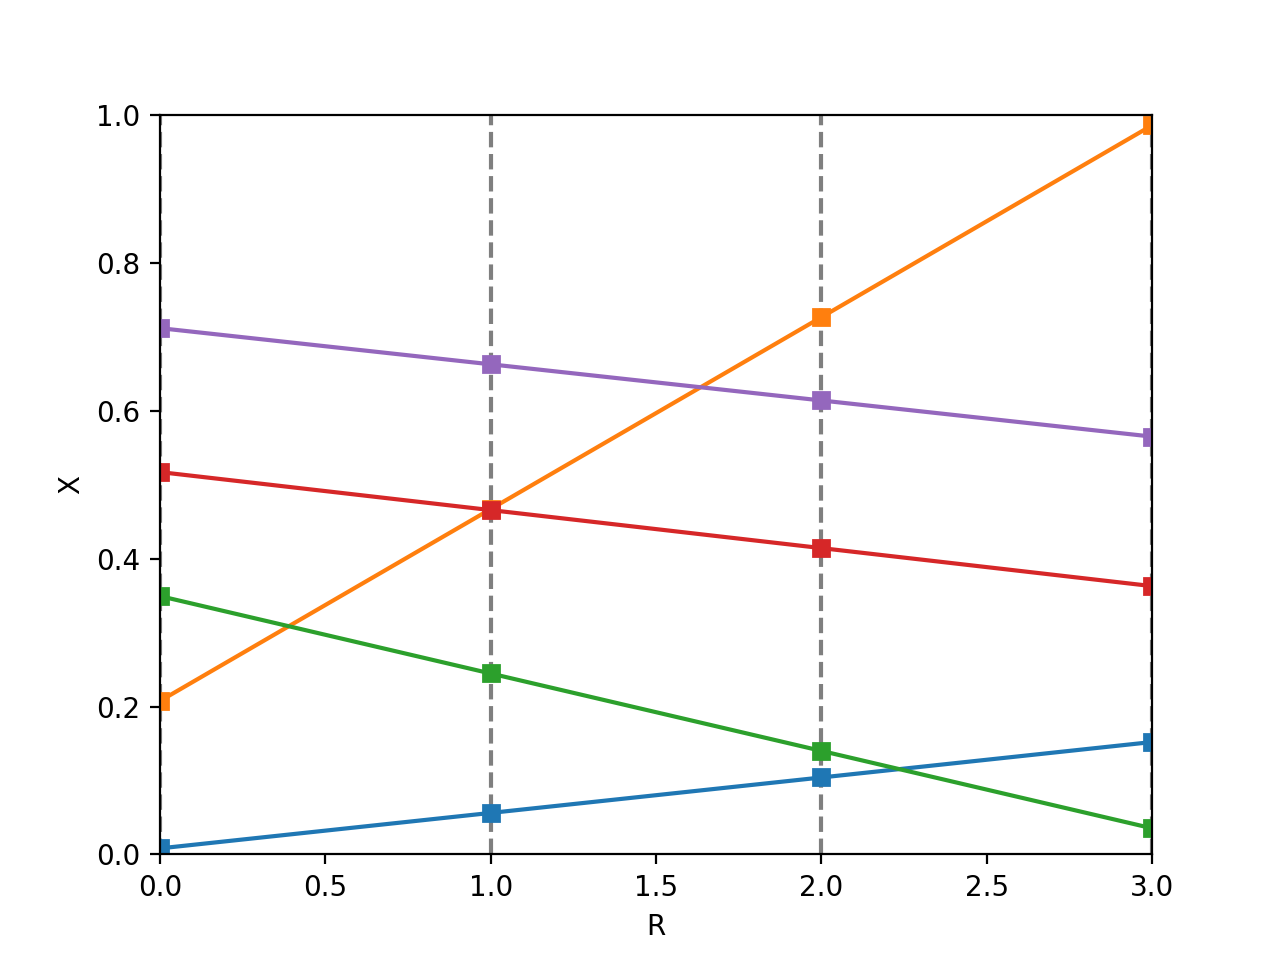

In [12]:
# Visualize the tracks
plt.figure()
for r in det_r:
    plt.plot([r, r], [0, 1], 'k--', alpha=0.5)
for i in range(x.shape[0]):
    plt.plot(det_r, x[i], 's-')
    plt.xlim((0, det_r[-1]))
    plt.ylim((0, 1))
    plt.xlabel('R')
    plt.ylabel('X')

## Adjacency development

Let's work on constructing adjacency and degree matrices.

The appropriate adjacency weight matrix for this data should work as follows:
- if the line between two hits on adjacent layers is fully contained in the detector, the adjacency is 1
- otherwise the adjacency is 0

In [13]:
hits_l = np.zeros_like(hits_x)
hits_l[:] = np.arange(0, num_det_layers)[:, None]
print('Position x')
print(hits_x)
print('Position r')
print(hits_r)
print('Layer')
print(hits_l)
print('Particle ID')
print(hits_pid)

Position x
[[ 0.00817044  0.20758205  0.34944277  0.51719767  0.711905  ]
 [ 0.05611567  0.2447409   0.46578201  0.46714213  0.66300331]
 [ 0.1040609   0.14003904  0.41436636  0.61410162  0.72670221]
 [ 0.03533718  0.15200613  0.3629507   0.56519992  0.98626229]]
Position r
[[ 0.  0.  0.  0.  0.]
 [ 1.  1.  1.  1.  1.]
 [ 2.  2.  2.  2.  2.]
 [ 3.  3.  3.  3.  3.]]
Layer
[[ 0.  0.  0.  0.  0.]
 [ 1.  1.  1.  1.  1.]
 [ 2.  2.  2.  2.  2.]
 [ 3.  3.  3.  3.  3.]]
Particle ID
[[0 1 2 3 4]
 [0 2 3 1 4]
 [0 2 3 4 1]
 [2 0 3 4 1]]


In [14]:
# Flatten the arrays
x = hits_x.flatten()
r = hits_r.flatten()
l = hits_l.flatten()
pid = hits_pid.flatten()

In [15]:
# Identify hits on adjacent layers
adj_l = (np.abs(l[None, :] - l[:, None]) == 1).astype(np.int)

# Calculate slopes
dr = r[None,:] - r[:,None]
dr[dr == 0] = 1e-7
slope = (x[None,:] - x[:,None]) / dr

# Calculate the entry point for each slope
x0 = x[None,:] - slope*r
# Calculate the exit point for each slope
xn = x[None,:] + slope * (det_r[-1] - r)
# Adjancency
adj_x0 = (x0 < 1) & (x0 > 0)
adj_xn = (xn < 1) & (xn > 0)
# Final adjacency matrix
adj = adj_l * adj_x0 * adj_xn

# Get the true adjacency matrix
adj_pid = (pid[None, :] == pid[:, None]).astype(np.int)

<IPython.core.display.Javascript object>


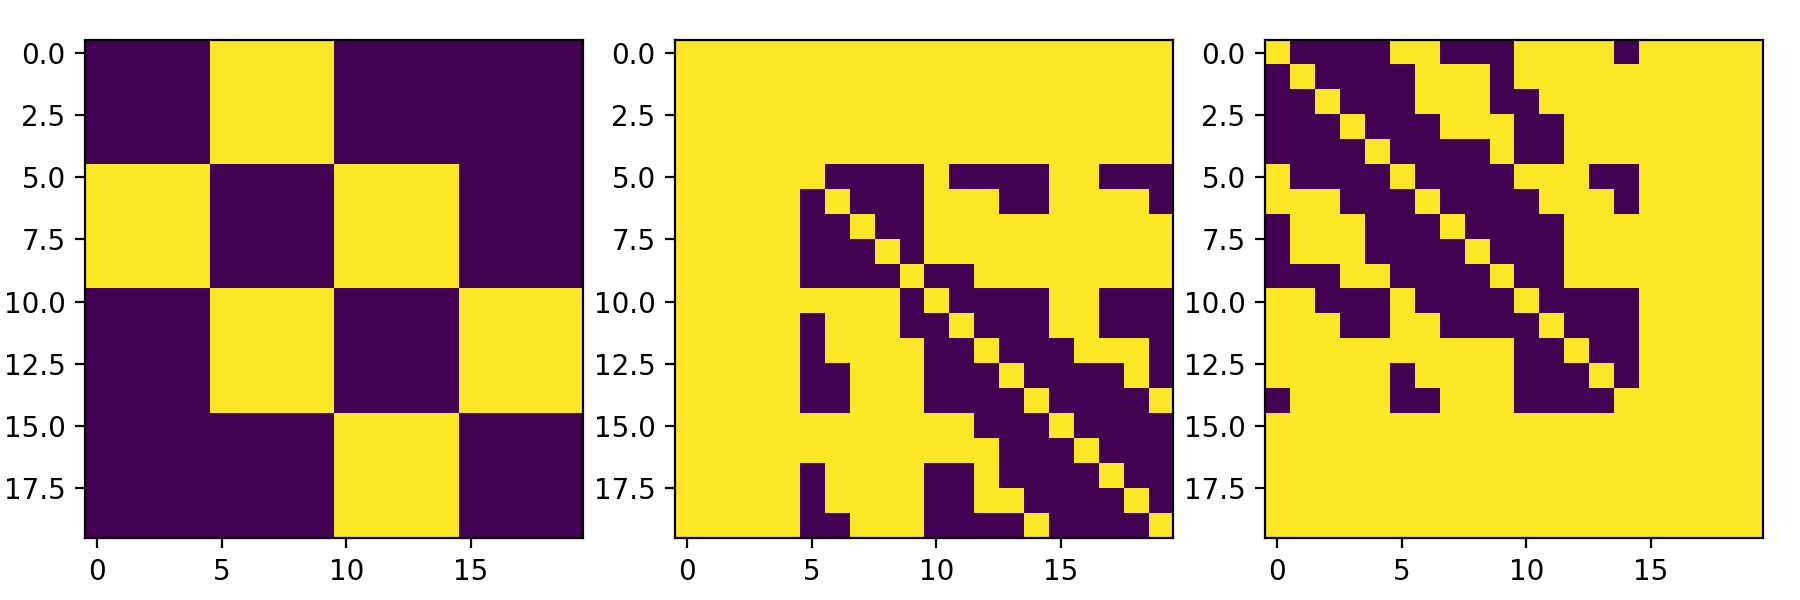

In [16]:
plt.figure(figsize=(9,3))
plt.subplot(131)
plt.imshow(adj_l)
plt.subplot(132)
plt.imshow(adj_x0)
plt.subplot(133)
plt.imshow(adj_xn)
plt.tight_layout()

<IPython.core.display.Javascript object>


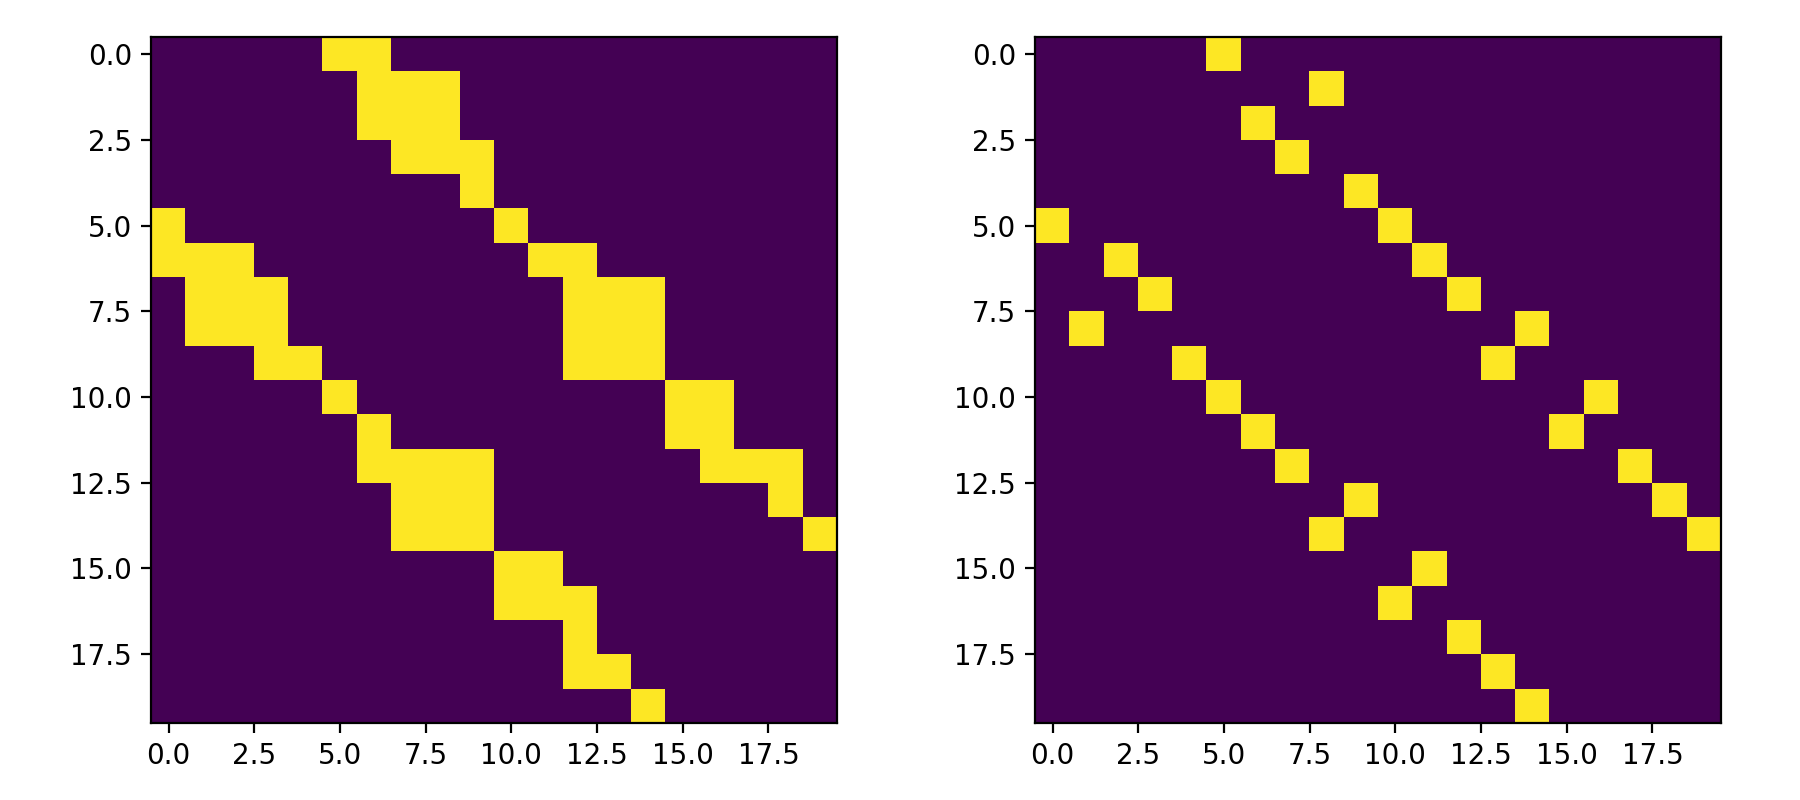

In [17]:
plt.figure(figsize=(9,4))
plt.subplot(121)
plt.imshow(adj)
plt.subplot(122)
plt.imshow(adj_pid*adj_l)
plt.tight_layout()

<IPython.core.display.Javascript object>


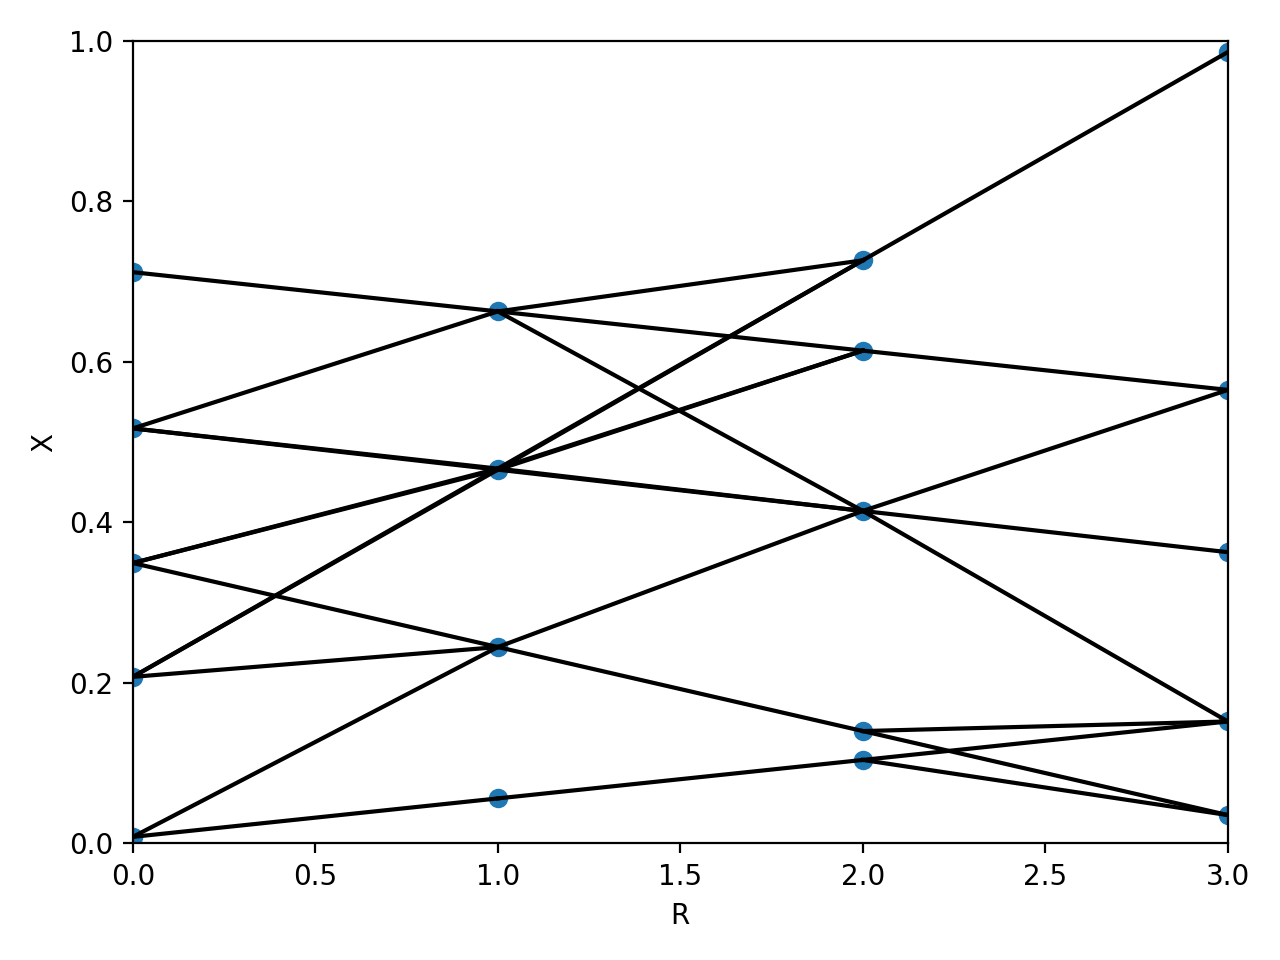

In [18]:
# Sanity check: need to draw these edges
plt.figure()

# Draw all the hits
plt.scatter(r, x)

# Loop over all hits
for i in range(x.shape[0]):
    # Loop over all other hits
    for j in range(i + 1, x.shape[0]):
        if adj[i,j] > 0:
            plt.plot([r[i], r[j]], [x[i], x[j]], 'k', alpha=adj[i,j])
plt.xlim((det_r[0], det_r[-1]))
plt.ylim((0, 1))
plt.xlabel('R')
plt.ylabel('X')
plt.tight_layout()

### Normalizing the adjacency

A typical thing to do is $D^{-1}A$, where $D$ is the diagonal degree matrix. This amounts to normalizing all edges coming into a node so they sum to 1.

The approach of Kipf and Welling is $\hat{D}^{-{1 \over 2}} \hat{A} \hat{D}^{-{1 \over 2}}$, where $\hat{A} = A + I$.

In [19]:
# The degree matrix is computed by summing the adjacency rows
deg = np.diagflat(adj.sum(axis=0))
# Inverse degree matrix
invdeg = np.diagflat(1. / adj.sum(axis=0))
# Normalized adjacency
adj_norm = invdeg.dot(adj)

In [20]:
# Symmetric (+ identity) normalized adjacency
adj_hat = np.eye(adj.shape[0]) + adj
inv_half_deg = np.diagflat(1. / np.sqrt(adj_hat.sum(axis=0)))
adj_hat_norm = inv_half_deg.dot(adj_hat.dot(inv_half_deg))

<IPython.core.display.Javascript object>


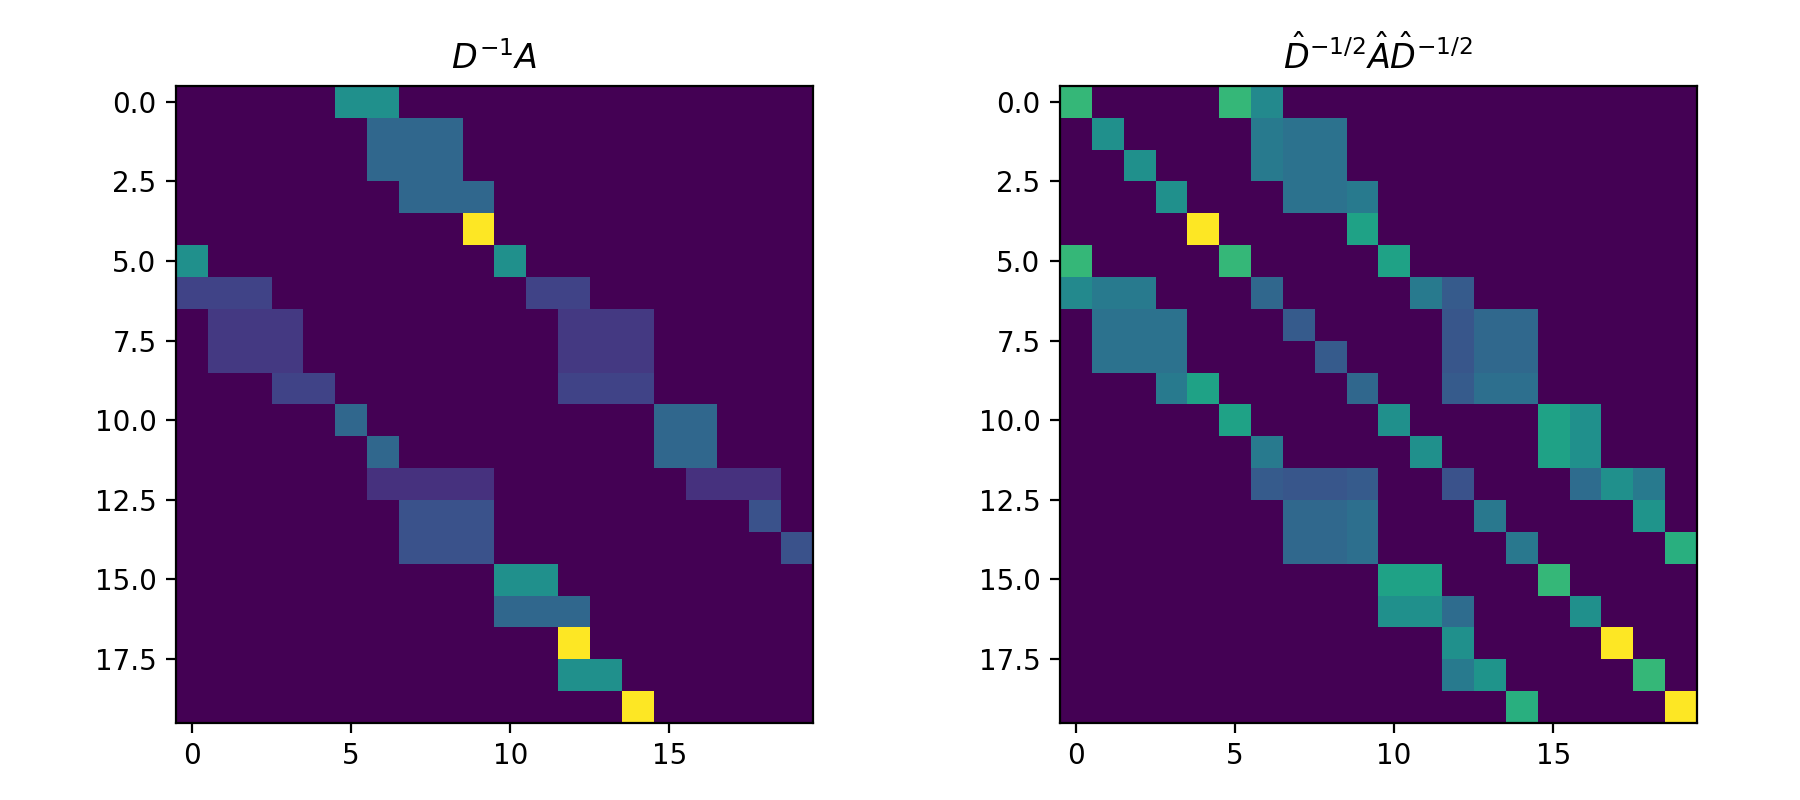

In [21]:
# Normalized adjacency matrix
plt.figure(figsize=(9,4))
plt.subplot(121)
plt.imshow(adj_norm)
plt.title('$D^{-1}A$')

plt.subplot(122)
plt.imshow(adj_hat_norm)
plt.title('$\hat{D}^{-1/2} \hat{A} \hat{D}^{-1/2}$')
plt.tight_layout()

## Graph convolutional layers

Now let's develop the operations that make up graph convolutions.

In [25]:
n_features = 2
n_hidden = 5

In [49]:
# Weight matrix has shape (features_in, features_out)
W = np.random.normal(size=(n_features, n_hidden))
b = np.zeros((1, n_hidden))

In [50]:
X = np.stack([hits_x, hits_r], axis=-1).reshape((-1, n_features))
X.shape

(20, 2)

In [51]:
# A*X*W
adj.dot(X).dot(W) + b

array([[ -8.88597163e-01,   1.50727941e-03,   2.35681778e-01,
          3.17123561e-01,  -1.67755138e+00],
       [ -6.00358140e-01,   1.07858424e+00,  -4.08858227e-01,
          6.60456283e-01,  -2.72563972e+00],
       [ -6.00358140e-01,   1.07858424e+00,  -4.08858227e-01,
          6.60456283e-01,  -2.72563972e+00],
       [ -1.78550186e-01,   1.69835002e+00,  -8.47850469e-01,
          7.66850620e-01,  -2.84616560e+00],
       [  7.26214637e-02,   7.60268371e-01,  -4.20138273e-01,
          2.88946627e-01,  -9.86478556e-01],
       [ -1.07882135e+00,  -2.77990625e-01,   4.33655618e-01,
          2.69142542e-01,  -1.62319741e+00],
       [ -1.25491676e+00,   7.70401131e-01,  -7.21913856e-02,
          7.65983318e-01,  -3.50433647e+00],
       [ -7.22635146e-01,   2.85961690e+00,  -1.31527442e+00,
          1.44150092e+00,  -5.58788462e+00],
       [ -7.22635146e-01,   2.85961690e+00,  -1.31527442e+00,
          1.44150092e+00,  -5.58788462e+00],
       [ -5.66442060e-01,   3.0891126

In [52]:
# D^-1 * A * X * W
adj_norm.dot(X).dot(W) + b

array([[ -4.44298582e-01,   7.53639704e-04,   1.17840889e-01,
          1.58561781e-01,  -8.38775692e-01],
       [ -2.00119380e-01,   3.59528081e-01,  -1.36286076e-01,
          2.20152094e-01,  -9.08546574e-01],
       [ -2.00119380e-01,   3.59528081e-01,  -1.36286076e-01,
          2.20152094e-01,  -9.08546574e-01],
       [ -5.95167288e-02,   5.66116674e-01,  -2.82616823e-01,
          2.55616873e-01,  -9.48721867e-01],
       [  7.26214637e-02,   7.60268371e-01,  -4.20138273e-01,
          2.88946627e-01,  -9.86478556e-01],
       [ -5.39410673e-01,  -1.38995312e-01,   2.16827809e-01,
          1.34571271e-01,  -8.11598707e-01],
       [ -2.50983353e-01,   1.54080226e-01,  -1.44382771e-02,
          1.53196664e-01,  -7.00867294e-01],
       [ -1.20439191e-01,   4.76602816e-01,  -2.19212404e-01,
          2.40250153e-01,  -9.31314103e-01],
       [ -1.20439191e-01,   4.76602816e-01,  -2.19212404e-01,
          2.40250153e-01,  -9.31314103e-01],
       [ -1.13288412e-01,   6.1782252

In [53]:
# D^(-1/2) * A * D^(-1/2) * X * W + b
adj_hat_norm.dot(X).dot(W) + b

array([[-0.25936104, -0.00917944,  0.0738614 ,  0.08857786, -0.4754247 ],
       [-0.06640895,  0.28285759, -0.131449  ,  0.14077947, -0.5431638 ],
       [-0.03064314,  0.33540858, -0.1686719 ,  0.14980083, -0.5533834 ],
       [ 0.09775228,  0.524061  , -0.3022981 ,  0.18218653, -0.59007064],
       [ 0.37993387,  0.74690784, -0.49487762,  0.17395613, -0.38734258],
       [-0.49086448, -0.12604009,  0.19707857,  0.12264466, -0.73921478],
       [-0.26781407,  0.17091098, -0.01883237,  0.16616071, -0.75746887],
       [-0.09116833,  0.57597535, -0.27939107,  0.27097279, -1.02296396],
       [-0.09097238,  0.57626326, -0.279595  ,  0.27102222, -1.02301995],
       [ 0.02569996,  0.8126531 , -0.4352685 ,  0.3273506 , -1.15234771],
       [-1.34202302, -0.4002168 ,  0.56813712,  0.31227782, -1.93882175],
       [-1.24851518, -0.31808456,  0.49995255,  0.31298173, -1.88388708],
       [-1.06334842,  0.20134985,  0.17683055,  0.4621173 , -2.30231371],
       [-0.45822644,  0.43466905, -0.1

## Generate a dataset

In [69]:
det_r = np.array([0, 1, 2, 3], dtype=np.float)
n_det_layers = det_r.shape[0]
n_events = 1024
n_tracks = 5

In [146]:
def generate_data(n_events, n_tracks, det_r):
    n_det_layers = det_r.shape[0]

    # Generate all the tracks we'll need
    tracks = np.stack([gen_tracks(n_events, det_r)
                       for i in range(n_tracks)], axis=1)

    # Sort according to the first hit position, so the labels are
    # consistently defined in terms of the first layer hit order.
    # Note: singleton ('None') idx axes indicate a repeat-broadcast.
    idx0 = np.arange(n_events)[:, None, None]
    idx1 = tracks[:, :, 0].argsort(axis=1)[:, :, None]
    idx2 = np.arange(n_det_layers)[None, None, :]
    tracks = tracks[[idx0, idx1, idx2]]
    tracks.shape

    # Now sort all hits on all layers by their position.
    # This sort index relative to previous sort gives us our hit labels.
    idx = np.argsort(tracks, axis=1)
    x = tracks[[idx0, idx, idx2]]
    
    # Transpose to shape (n_event, n_layer, n_hit)
    return x.transpose([0,2,1]), idx.transpose([0,2,1])

In [184]:
# Hit position and label
hits_x, hits_y = generate_data(n_events, n_tracks, det_r)
# Hit radius
hits_r = np.broadcast_to(det_r[None, :, None], hits_x.shape)
# Layer number
hits_l = np.broadcast_to(np.arange(n_det_layers)[None, :, None], hits_x.shape)
print(hits_x.shape, hits_y.shape)

# Flattened arrays
x, y, r, l = [a.reshape((n_events, -1)) for a in [hits_x, hits_y, hits_r, hits_l]]
print(map(np.shape, [x, y, r, l]))

(1024, 4, 5) (1024, 4, 5)
[(1024, 20), (1024, 20), (1024, 20), (1024, 20)]


<IPython.core.display.Javascript object>


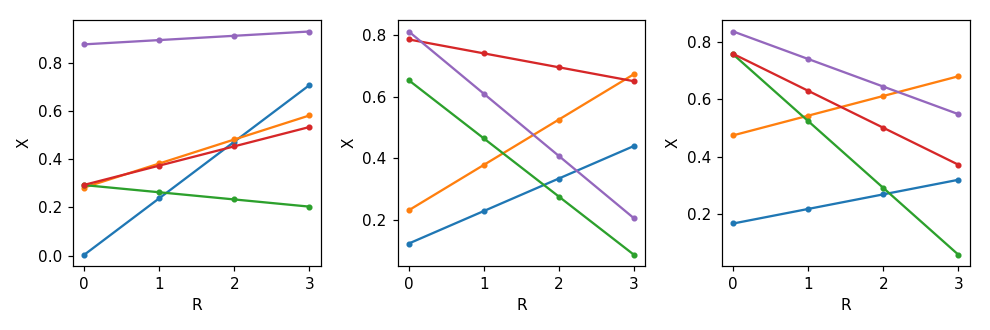

In [241]:
# As a sanity check, plot a few events
nrows, ncols = 1, 3
plt.figure(figsize=(9,3))

for i in range(nrows*ncols):
    plt.subplot(nrows, ncols, i+1)
    xi, yi = x[i], y[i]
    for j in range(n_tracks):
        plt.plot(det_r, xi[yi==j], '.-')
    plt.xlabel('R')
    plt.ylabel('X')
plt.tight_layout()

### Calculating adjacency

Extend the adjacency calculations to work on batches or full datasets

Adjacency tensor will have shape (n_events, n_hits, n_hits), where n_hits = n_tracks * n_det_layers.

In [276]:
def calc_adjacency(x, r, l, y):
    """Calculate toy data adjacency matrices"""
    # Detector layer adjacency
    adj_l = (np.abs(l[:, None, :] - l[:, :, None]) == 1).astype(np.int)
    # Hit-pair-wise slopes
    dx = x[:, None, :] - x[:, :, None]
    dr = r[:, None, :] - r[:, :, None]
    # Div-by-zero protection
    dr[dr == 0] = 1e-7
    slope = dx / dr
    # Entry and exit points for each slope
    rn = r.max()
    x0 = x[:, None, :] - slope * r[:, None, :]
    xn = x[:, None, :] + slope * (rn - r[:, None, :])
    # Adjacency from entry and exit constraints
    adj_x0 = (x0 < 1) & (x0 > 0)
    adj_xn = (xn < 1) & (xn > 0)
    # Final combined adjacency matrices
    adj = adj_l * adj_x0 * adj_xn
    # True adjacency matrix
    adj_y = (y[:, None, :] == y[:, :, None]) * adj_l
    return adj, adj_y

In [277]:
# Adjacency matrices for all events
adj, adj_y = calc_adjacency(x, r, l, y)

<IPython.core.display.Javascript object>


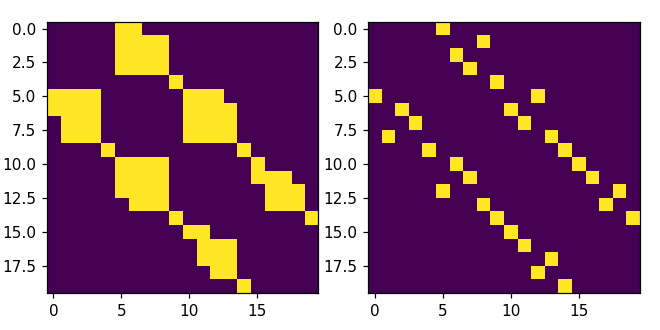

<IPython.core.display.Javascript object>


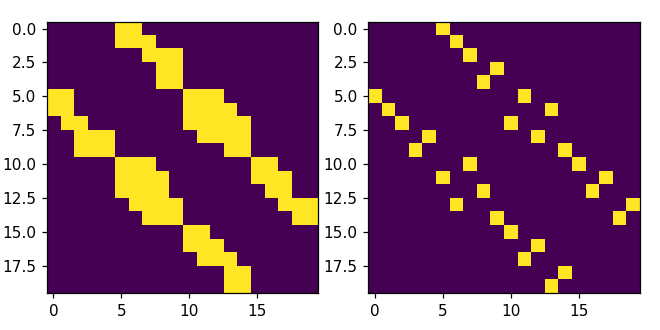

In [279]:
# Draw some adjacency matrices
for i in range(2):
    plt.figure(figsize=(6, 3))
    plt.subplot(121)
    plt.imshow(adj[i])
    plt.subplot(122)
    plt.imshow(adj_y[i])
    plt.tight_layout()

## Discussion

What next? Should I start developing a pytorch model?

## PyTorch implementation of graph convolutions

Now let's translate the graph conv operations into some PyTorch code. It doesn't need to be in perfect shape for training yet, but let's get the machinery in place to at least do a forward pass of a graph conv layer.

Then we should think about what a good first model task will be. E.g., hit classification? Segment classification?